In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import tensorflow as tf
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt
%matplotlib inline

/home/motoofi/miniconda2/envs/mlp/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_error_and_accuracy(X,Y,error,sess):
    err = 0
    err += sess.run(error, feed_dict={inputs: X, targets: Y})
    return err

In [3]:
def make_kaggle_submission_file(predictions, modelName):
    ofile  = open('./results/Kaggle_submision_{0}.csv'.format(modelName), "wb")
    writer = csv.writer(ofile)
    writer.writerow(["Id","PRP"])
    for i,score in enumerate(predictions):
        writer.writerow([i,int(round(score[0]))])

    ofile.close()

In [4]:
# Loading data set
data_x_train = pd.read_csv("./X_train.csv")
X_test = pd.read_csv("./X_test.csv")
data_y_train = pd.read_csv("./y_train.csv")
# Splitting data set into training and validation sets. 20% of data set is used for validation.
X_train, X_val, Y_train, Y_val = train_test_split(data_x_train, data_y_train, test_size = 0.2, random_state = 0)

In [5]:
#Feature scaling
# It is not needed to scale Ys because they indicate what class a data point belongs to. They are either 1 or 2.
sc_X = StandardScaler()
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train))
X_test_scaled = pd.DataFrame(sc_X.transform(X_test))
X_val_scaled = pd.DataFrame(sc_X.transform(X_val))

sc_Y = StandardScaler()
Y_train_scaled = pd.DataFrame(sc_Y.fit_transform(Y_train['PRP'].reshape(-1,1)))
Y_val_scaled = pd.DataFrame(sc_Y.transform(Y_val['PRP'].reshape(-1,1)))

/home/motoofi/miniconda2/envs/mlp/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/home/motoofi/miniconda2/envs/mlp/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/motoofi/miniconda2/envs/mlp/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


In [6]:
w = tf.Variable(tf.truncated_normal([6, 1], mean=0.0, stddev=1.0, dtype=tf.float64))
b = tf.Variable(tf.zeros(1, dtype = tf.float64))

In [7]:
learning_rate = 0.0001
epochs = 5000
l2=0.2

inputs = tf.placeholder(tf.float64, [None, 6], 'inputs')
targets = tf.placeholder(tf.float64, [None,1], 'targets')
predictions = (tf.add(b, tf.matmul(inputs, w)))
error = tf.reduce_mean(tf.square(targets - predictions)+(l2*tf.nn.l2_loss(w)))
#regularizer = tf.nn.l2_loss(weights)
#loss = tf.reduce_mean(loss + beta * regularizer)

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(error)

sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [8]:
errors_tr = list()
errors_va = list()
for e in range(epochs):
    running_error = 0.
    _, batch_error = sess.run([optimizer, error], feed_dict={inputs: X_train_scaled, targets: Y_train_scaled})
    
    running_error += batch_error
    errors_tr.append(running_error)
    print('End of epoch {0}: running error average = {1:.2f}'.format(e + 1, running_error))
    if e % 10 == 0:
        errors_va.append(get_error_and_accuracy(X_val_scaled,Y_val_scaled,error,sess))
        print('Valid data: Error={0:.2f}'.format(errors_va[-1]))
        
pre = sess.run(predictions, feed_dict={inputs: X_test_scaled})


End of epoch 1: running error average = 10.38
Valid data: Error=16.10
End of epoch 2: running error average = 10.37
End of epoch 3: running error average = 10.36
End of epoch 4: running error average = 10.35
End of epoch 5: running error average = 10.34
End of epoch 6: running error average = 10.33
End of epoch 7: running error average = 10.32
End of epoch 8: running error average = 10.31
End of epoch 9: running error average = 10.30
End of epoch 10: running error average = 10.29
End of epoch 11: running error average = 10.28
Valid data: Error=15.90
End of epoch 12: running error average = 10.27
End of epoch 13: running error average = 10.26
End of epoch 14: running error average = 10.25
End of epoch 15: running error average = 10.24
End of epoch 16: running error average = 10.23
End of epoch 17: running error average = 10.22
End of epoch 18: running error average = 10.21
End of epoch 19: running error average = 10.20
End of epoch 20: running error average = 10.19
End of epoch 21: runn

End of epoch 257: running error average = 8.19
End of epoch 258: running error average = 8.19
End of epoch 259: running error average = 8.18
End of epoch 260: running error average = 8.17
End of epoch 261: running error average = 8.16
Valid data: Error=11.69
End of epoch 262: running error average = 8.16
End of epoch 263: running error average = 8.15
End of epoch 264: running error average = 8.14
End of epoch 265: running error average = 8.14
End of epoch 266: running error average = 8.13
End of epoch 267: running error average = 8.12
End of epoch 268: running error average = 8.11
End of epoch 269: running error average = 8.11
End of epoch 270: running error average = 8.10
End of epoch 271: running error average = 8.09
Valid data: Error=11.55
End of epoch 272: running error average = 8.09
End of epoch 273: running error average = 8.08
End of epoch 274: running error average = 8.07
End of epoch 275: running error average = 8.06
End of epoch 276: running error average = 8.06
End of epoch

End of epoch 478: running error average = 6.77
End of epoch 479: running error average = 6.76
End of epoch 480: running error average = 6.76
End of epoch 481: running error average = 6.75
Valid data: Error=9.01
End of epoch 482: running error average = 6.75
End of epoch 483: running error average = 6.74
End of epoch 484: running error average = 6.74
End of epoch 485: running error average = 6.73
End of epoch 486: running error average = 6.73
End of epoch 487: running error average = 6.72
End of epoch 488: running error average = 6.71
End of epoch 489: running error average = 6.71
End of epoch 490: running error average = 6.70
End of epoch 491: running error average = 6.70
Valid data: Error=8.91
End of epoch 492: running error average = 6.69
End of epoch 493: running error average = 6.69
End of epoch 494: running error average = 6.68
End of epoch 495: running error average = 6.67
End of epoch 496: running error average = 6.67
End of epoch 497: running error average = 6.66
End of epoch 4

Valid data: Error=6.79
End of epoch 732: running error average = 5.52
End of epoch 733: running error average = 5.52
End of epoch 734: running error average = 5.51
End of epoch 735: running error average = 5.51
End of epoch 736: running error average = 5.50
End of epoch 737: running error average = 5.50
End of epoch 738: running error average = 5.50
End of epoch 739: running error average = 5.49
End of epoch 740: running error average = 5.49
End of epoch 741: running error average = 5.48
Valid data: Error=6.72
End of epoch 742: running error average = 5.48
End of epoch 743: running error average = 5.47
End of epoch 744: running error average = 5.47
End of epoch 745: running error average = 5.47
End of epoch 746: running error average = 5.46
End of epoch 747: running error average = 5.46
End of epoch 748: running error average = 5.45
End of epoch 749: running error average = 5.45
End of epoch 750: running error average = 5.45
End of epoch 751: running error average = 5.44
Valid data: Er

End of epoch 1039: running error average = 4.41
End of epoch 1040: running error average = 4.41
End of epoch 1041: running error average = 4.41
Valid data: Error=4.90
End of epoch 1042: running error average = 4.40
End of epoch 1043: running error average = 4.40
End of epoch 1044: running error average = 4.40
End of epoch 1045: running error average = 4.39
End of epoch 1046: running error average = 4.39
End of epoch 1047: running error average = 4.39
End of epoch 1048: running error average = 4.38
End of epoch 1049: running error average = 4.38
End of epoch 1050: running error average = 4.38
End of epoch 1051: running error average = 4.38
Valid data: Error=4.85
End of epoch 1052: running error average = 4.37
End of epoch 1053: running error average = 4.37
End of epoch 1054: running error average = 4.37
End of epoch 1055: running error average = 4.36
End of epoch 1056: running error average = 4.36
End of epoch 1057: running error average = 4.36
End of epoch 1058: running error average =

End of epoch 1354: running error average = 3.59
End of epoch 1355: running error average = 3.59
End of epoch 1356: running error average = 3.59
End of epoch 1357: running error average = 3.58
End of epoch 1358: running error average = 3.58
End of epoch 1359: running error average = 3.58
End of epoch 1360: running error average = 3.58
End of epoch 1361: running error average = 3.58
Valid data: Error=3.62
End of epoch 1362: running error average = 3.57
End of epoch 1363: running error average = 3.57
End of epoch 1364: running error average = 3.57
End of epoch 1365: running error average = 3.57
End of epoch 1366: running error average = 3.56
End of epoch 1367: running error average = 3.56
End of epoch 1368: running error average = 3.56
End of epoch 1369: running error average = 3.56
End of epoch 1370: running error average = 3.56
End of epoch 1371: running error average = 3.55
Valid data: Error=3.58
End of epoch 1372: running error average = 3.55
End of epoch 1373: running error average =

End of epoch 1680: running error average = 2.97
End of epoch 1681: running error average = 2.97
Valid data: Error=2.77
End of epoch 1682: running error average = 2.97
End of epoch 1683: running error average = 2.97
End of epoch 1684: running error average = 2.97
End of epoch 1685: running error average = 2.96
End of epoch 1686: running error average = 2.96
End of epoch 1687: running error average = 2.96
End of epoch 1688: running error average = 2.96
End of epoch 1689: running error average = 2.96
End of epoch 1690: running error average = 2.96
End of epoch 1691: running error average = 2.95
Valid data: Error=2.74
End of epoch 1692: running error average = 2.95
End of epoch 1693: running error average = 2.95
End of epoch 1694: running error average = 2.95
End of epoch 1695: running error average = 2.95
End of epoch 1696: running error average = 2.95
End of epoch 1697: running error average = 2.94
End of epoch 1698: running error average = 2.94
End of epoch 1699: running error average =

End of epoch 2000: running error average = 2.52
End of epoch 2001: running error average = 2.52
Valid data: Error=2.20
End of epoch 2002: running error average = 2.52
End of epoch 2003: running error average = 2.52
End of epoch 2004: running error average = 2.52
End of epoch 2005: running error average = 2.52
End of epoch 2006: running error average = 2.51
End of epoch 2007: running error average = 2.51
End of epoch 2008: running error average = 2.51
End of epoch 2009: running error average = 2.51
End of epoch 2010: running error average = 2.51
End of epoch 2011: running error average = 2.51
Valid data: Error=2.18
End of epoch 2012: running error average = 2.51
End of epoch 2013: running error average = 2.51
End of epoch 2014: running error average = 2.50
End of epoch 2015: running error average = 2.50
End of epoch 2016: running error average = 2.50
End of epoch 2017: running error average = 2.50
End of epoch 2018: running error average = 2.50
End of epoch 2019: running error average =

End of epoch 2328: running error average = 2.17
End of epoch 2329: running error average = 2.17
End of epoch 2330: running error average = 2.17
End of epoch 2331: running error average = 2.17
Valid data: Error=1.80
End of epoch 2332: running error average = 2.17
End of epoch 2333: running error average = 2.17
End of epoch 2334: running error average = 2.16
End of epoch 2335: running error average = 2.16
End of epoch 2336: running error average = 2.16
End of epoch 2337: running error average = 2.16
End of epoch 2338: running error average = 2.16
End of epoch 2339: running error average = 2.16
End of epoch 2340: running error average = 2.16
End of epoch 2341: running error average = 2.16
Valid data: Error=1.79
End of epoch 2342: running error average = 2.16
End of epoch 2343: running error average = 2.16
End of epoch 2344: running error average = 2.16
End of epoch 2345: running error average = 2.15
End of epoch 2346: running error average = 2.15
End of epoch 2347: running error average =

End of epoch 2655: running error average = 1.90
End of epoch 2656: running error average = 1.90
End of epoch 2657: running error average = 1.90
End of epoch 2658: running error average = 1.90
End of epoch 2659: running error average = 1.90
End of epoch 2660: running error average = 1.89
End of epoch 2661: running error average = 1.89
Valid data: Error=1.52
End of epoch 2662: running error average = 1.89
End of epoch 2663: running error average = 1.89
End of epoch 2664: running error average = 1.89
End of epoch 2665: running error average = 1.89
End of epoch 2666: running error average = 1.89
End of epoch 2667: running error average = 1.89
End of epoch 2668: running error average = 1.89
End of epoch 2669: running error average = 1.89
End of epoch 2670: running error average = 1.89
End of epoch 2671: running error average = 1.89
Valid data: Error=1.51
End of epoch 2672: running error average = 1.89
End of epoch 2673: running error average = 1.89
End of epoch 2674: running error average =

End of epoch 2989: running error average = 1.68
End of epoch 2990: running error average = 1.68
End of epoch 2991: running error average = 1.68
Valid data: Error=1.31
End of epoch 2992: running error average = 1.68
End of epoch 2993: running error average = 1.68
End of epoch 2994: running error average = 1.68
End of epoch 2995: running error average = 1.68
End of epoch 2996: running error average = 1.67
End of epoch 2997: running error average = 1.67
End of epoch 2998: running error average = 1.67
End of epoch 2999: running error average = 1.67
End of epoch 3000: running error average = 1.67
End of epoch 3001: running error average = 1.67
Valid data: Error=1.31
End of epoch 3002: running error average = 1.67
End of epoch 3003: running error average = 1.67
End of epoch 3004: running error average = 1.67
End of epoch 3005: running error average = 1.67
End of epoch 3006: running error average = 1.67
End of epoch 3007: running error average = 1.67
End of epoch 3008: running error average =

End of epoch 3317: running error average = 1.50
End of epoch 3318: running error average = 1.50
End of epoch 3319: running error average = 1.50
End of epoch 3320: running error average = 1.50
End of epoch 3321: running error average = 1.50
Valid data: Error=1.16
End of epoch 3322: running error average = 1.50
End of epoch 3323: running error average = 1.50
End of epoch 3324: running error average = 1.50
End of epoch 3325: running error average = 1.50
End of epoch 3326: running error average = 1.50
End of epoch 3327: running error average = 1.50
End of epoch 3328: running error average = 1.50
End of epoch 3329: running error average = 1.50
End of epoch 3330: running error average = 1.50
End of epoch 3331: running error average = 1.50
Valid data: Error=1.16
End of epoch 3332: running error average = 1.50
End of epoch 3333: running error average = 1.50
End of epoch 3334: running error average = 1.50
End of epoch 3335: running error average = 1.49
End of epoch 3336: running error average =

End of epoch 3646: running error average = 1.36
End of epoch 3647: running error average = 1.36
End of epoch 3648: running error average = 1.36
End of epoch 3649: running error average = 1.36
End of epoch 3650: running error average = 1.36
End of epoch 3651: running error average = 1.36
Valid data: Error=1.04
End of epoch 3652: running error average = 1.36
End of epoch 3653: running error average = 1.36
End of epoch 3654: running error average = 1.35
End of epoch 3655: running error average = 1.35
End of epoch 3656: running error average = 1.35
End of epoch 3657: running error average = 1.35
End of epoch 3658: running error average = 1.35
End of epoch 3659: running error average = 1.35
End of epoch 3660: running error average = 1.35
End of epoch 3661: running error average = 1.35
Valid data: Error=1.04
End of epoch 3662: running error average = 1.35
End of epoch 3663: running error average = 1.35
End of epoch 3664: running error average = 1.35
End of epoch 3665: running error average =

End of epoch 3975: running error average = 1.24
End of epoch 3976: running error average = 1.24
End of epoch 3977: running error average = 1.24
End of epoch 3978: running error average = 1.23
End of epoch 3979: running error average = 1.23
End of epoch 3980: running error average = 1.23
End of epoch 3981: running error average = 1.23
Valid data: Error=0.95
End of epoch 3982: running error average = 1.23
End of epoch 3983: running error average = 1.23
End of epoch 3984: running error average = 1.23
End of epoch 3985: running error average = 1.23
End of epoch 3986: running error average = 1.23
End of epoch 3987: running error average = 1.23
End of epoch 3988: running error average = 1.23
End of epoch 3989: running error average = 1.23
End of epoch 3990: running error average = 1.23
End of epoch 3991: running error average = 1.23
Valid data: Error=0.94
End of epoch 3992: running error average = 1.23
End of epoch 3993: running error average = 1.23
End of epoch 3994: running error average =

End of epoch 4313: running error average = 1.13
End of epoch 4314: running error average = 1.13
End of epoch 4315: running error average = 1.13
End of epoch 4316: running error average = 1.13
End of epoch 4317: running error average = 1.13
End of epoch 4318: running error average = 1.13
End of epoch 4319: running error average = 1.13
End of epoch 4320: running error average = 1.13
End of epoch 4321: running error average = 1.13
Valid data: Error=0.86
End of epoch 4322: running error average = 1.13
End of epoch 4323: running error average = 1.13
End of epoch 4324: running error average = 1.13
End of epoch 4325: running error average = 1.13
End of epoch 4326: running error average = 1.13
End of epoch 4327: running error average = 1.12
End of epoch 4328: running error average = 1.12
End of epoch 4329: running error average = 1.12
End of epoch 4330: running error average = 1.12
End of epoch 4331: running error average = 1.12
Valid data: Error=0.86
End of epoch 4332: running error average =

End of epoch 4634: running error average = 1.04
End of epoch 4635: running error average = 1.04
End of epoch 4636: running error average = 1.04
End of epoch 4637: running error average = 1.04
End of epoch 4638: running error average = 1.04
End of epoch 4639: running error average = 1.04
End of epoch 4640: running error average = 1.04
End of epoch 4641: running error average = 1.04
Valid data: Error=0.79
End of epoch 4642: running error average = 1.04
End of epoch 4643: running error average = 1.04
End of epoch 4644: running error average = 1.04
End of epoch 4645: running error average = 1.04
End of epoch 4646: running error average = 1.04
End of epoch 4647: running error average = 1.04
End of epoch 4648: running error average = 1.04
End of epoch 4649: running error average = 1.04
End of epoch 4650: running error average = 1.04
End of epoch 4651: running error average = 1.04
Valid data: Error=0.79
End of epoch 4652: running error average = 1.04
End of epoch 4653: running error average =

End of epoch 4965: running error average = 0.96
End of epoch 4966: running error average = 0.96
End of epoch 4967: running error average = 0.96
End of epoch 4968: running error average = 0.96
End of epoch 4969: running error average = 0.96
End of epoch 4970: running error average = 0.96
End of epoch 4971: running error average = 0.96
Valid data: Error=0.73
End of epoch 4972: running error average = 0.96
End of epoch 4973: running error average = 0.96
End of epoch 4974: running error average = 0.96
End of epoch 4975: running error average = 0.96
End of epoch 4976: running error average = 0.96
End of epoch 4977: running error average = 0.96
End of epoch 4978: running error average = 0.96
End of epoch 4979: running error average = 0.96
End of epoch 4980: running error average = 0.96
End of epoch 4981: running error average = 0.96
Valid data: Error=0.73
End of epoch 4982: running error average = 0.96
End of epoch 4983: running error average = 0.96
End of epoch 4984: running error average =

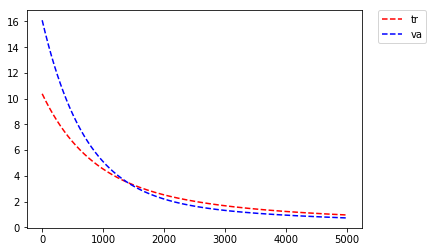

In [9]:
plt.plot( range(0,epochs),errors_tr, 'r--',label='tr')
plt.plot(range(0,epochs,10),errors_va, 'b--',label='va')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
inversed_predictions = sc_Y.inverse_transform(pre)
inversed_predictions

array([[  48.55859965],
       [  28.23352281],
       [ 174.54963433],
       [ 297.11279748],
       [ 209.11705395],
       [  24.75661018],
       [  56.23743294],
       [-315.71501242],
       [  64.48001616],
       [ 180.36606109],
       [  72.35165272],
       [ 390.22330157],
       [  23.13425722],
       [ 332.68978393],
       [ 612.79538126],
       [ 131.56509469],
       [  43.78981885],
       [  91.33337804],
       [  81.02561211],
       [ 108.33470801],
       [  61.15206692],
       [  53.13353757],
       [ 651.87726857],
       [  40.37764546],
       [ 124.96266563],
       [ 117.08486615],
       [ 150.77133664],
       [-122.25317622],
       [  98.46946776],
       [ 132.32487642],
       [  35.24753636],
       [ 126.85341329],
       [  90.91367097],
       [ 214.80623467],
       [ 170.55189594],
       [  44.03068233],
       [  48.50278043],
       [ 117.68322654],
       [  67.0589133 ],
       [ 112.16881572],
       [ 339.5251293 ]])

In [11]:
import csv
make_kaggle_submission_file(inversed_predictions,"lr={0},l2={1},ep={2}".format(learning_rate,l2,epochs))